# Gyroscope Data Run

This is a Jupyter notebook. It provides an environmment for creating programming notebooks that allow a mix of text, code, and output among other things.

## setup to rerun

To be able to rerun the following, you will need some software on your machine.

For Windows users, install python3. Ensure that you select the option to add it to your path.

Open a command prompt or terminal and run the following:

```
pip3 install virtualenv
virtualenv venv
```

For Windows users run:

```
venv\Scripts\activate
```

For macOS or Linux run:

```
source venv/bin/activate
```

For either, run the following:

```
pip3 install -r requirements.txt
jupyter notebook
```

Open "Gyro Ab=nalysis.ipynb" from the the newly opened webpage.
Select "kernel" from the top followed by "Restart & run all". If you see the plots regenerated and no red output everything was successful.

To fully reproduce this analysis, you would have to convert the original output file to a csv. The way this was originally done is sufficiently complex that it will be left out. If attempting to redi this, it is encouraged to try a reproducable method.

## Analysis

On 7/31/17, we ran a P-Controller robot based on the gyroscope data. We had two encoders (different models) running as well, so I decided to look at the data.

The run was roughly one second.

First thing to do is set up our environment

In [1]:
# allows graphs to render in page
%matplotlib inline
import pandas as pd # data analysus library

I mangled together the data in the word doc into a csv. I don't want to go into detail, but I will likely have us try better methods of recording data in the future,

Changes were not made to the file, except the minimal to make it a csv.

In [2]:
data = pd.read_csv('data.csv')
data[:3] # first 3 rows

,time,ignore,gyro,enc1,enc2
0,1501552636402,0.000075,0.000150,0.0,-5.0
1,1501552636427,-0.000138,-0.000138,0.0,-5.0
2,1501552636442,-0.103075,-0.103075,4.0,-40.0


The above has a few weird features.

The time doesn't look useful. This is what is known as unix time, the number of milliseconds since January 1, 1970.

There is a column that I labeled ignore. There were two gyroscope readings. The second one was deemed more useful.

The encoders are going in opposite directions. It is easier to consider forwards to be positive.

Here we will manipulate the data to make it a bit cleaner. The time is still off by an hour but that is unimportant for our use case.

In [3]:
del data['ignore']
data.enc2 = -1 * data.enc2
data['time'] = pd.DatetimeIndex(pd.to_datetime(data['time'], unit='ms'))\
                 .tz_localize('UTC' )\
                 .tz_convert('America/New_York')
data.set_index('time', inplace=True)
data[:3]

,gyro,enc1,enc2
time,,,
2017-07-31 21:57:16.402000-04:00,0.000150,0.0,5.0
2017-07-31 21:57:16.427000-04:00,-0.000138,0.0,5.0
2017-07-31 21:57:16.442000-04:00,-0.103075,4.0,40.0


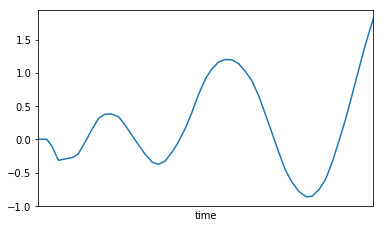

In [4]:
data['gyro'].plot()

The above data plot is our gyroscope data, It shows oscillation, but unfortunately it shows an unstable system where error grows over time,

Now we need to look into the encoders. Due to the different models, we will need to apply a correction factor, To do so, I have chosen a data point where the wheel turns should be equal (0 angle). I have found a near-zero point and chose to use that,

In [5]:
data.loc['2017-07-31 21:57:17.303000-04:00']

gyro      -0.00115
enc1     849.00000
enc2    2388.00000
Name: 2017-07-31 21:57:17.303000-04:00, dtype: float64

Now, let's attempt to use this to create a graph that should be proportional to angle.

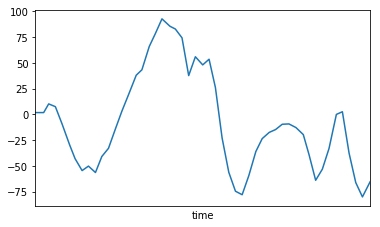

In [6]:
(849 / 2388 *(data.enc2) - (data.enc1)).plot()

Unfortunately, we had no luck with this,

What do we do now?

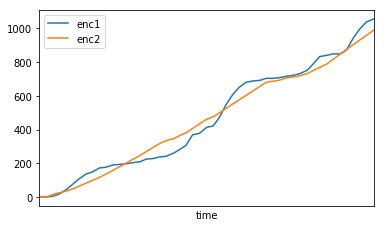

In [7]:
encs = data[['enc1', 'enc2']].copy(deep=True)
encs.enc2 = 849 / 2388 * encs.enc2
encs.plot()